In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [3]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68', 'Mass_u68',
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [4]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_filled_preprocessed.csv")

In [5]:
data.columns

Index(['Source_Name', 'Total_flux', 'Peak_flux', 'S_Code', 'EBV',
       'FUV_flux_corr', 'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr',
       'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68',
       'Mass_u68', 'Source', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16',
       'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flu

In [6]:
data.isna().sum()

Source_Name              0
Total_flux               0
Peak_flux                0
S_Code                   0
EBV                      0
FUV_flux_corr            0
NUV_flux_corr            0
u_flux_corr              0
Bw_flux_corr             0
R_flux_corr              0
I_flux_corr              0
z_flux_corr              0
z_Subaru_flux_corr       0
y_flux_corr              0
J_flux_corr              0
H_flux_corr              0
K_flux_corr              0
Ks_flux_corr             0
ch1_flux_corr            0
ch2_flux_corr            0
ch3_flux_corr            0
ch4_flux_corr            0
F_MIPS_24                0
F_PACS_100               0
F_PACS_160               0
F_SPIRE_250              0
F_SPIRE_350              0
F_SPIRE_500              0
Z_BEST                   0
Mass_median              0
Mass_l68                 0
Mass_u68                 0
Source                   0
AGN_final                0
RadioAGN_final           0
Classification           0
Radio_excess            21
A

In [7]:
X = data[features_num]
y = data[y_column]

In [8]:
le = LabelEncoder()
labels = np.unique(y.astype(str))
y = le.fit_transform(y)

In [9]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [10]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [11]:
# Imputing missing categorical features
imp = SimpleImputer(strategy="most_frequent")

# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

In [12]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

(array([10186.,     0.,     0.,  1062.,     0.,     0.,  5514.,     0.,
            0., 45325.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

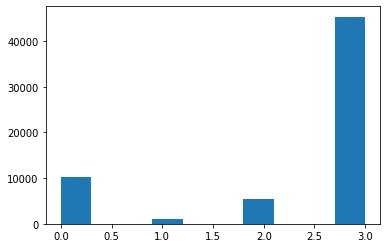

In [219]:
plt.hist(y_train)

In [220]:
np.unique(classes_weights)

array([ 0.3424545 ,  1.52383173,  2.81497098, 14.6155838 ])

# Random forest

In [221]:
clf = RandomForestClassifier(n_estimators=200, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight={0: 3, 1: 1000, 2: 1.5, 3: 0.5},
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1000, 2: 1.5, 3: 0.5},
                       max_features=None, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [222]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8109    0.5498    0.6553      2581
quasar-like radio AGN / high-excitation radio galaxy     0.4828    0.1556    0.2353       270
                                     radio-quiet AGN     0.7609    0.5140    0.6136      1356
                                 star-forming galaxy     0.8531    0.9627    0.9046     11315

                                            accuracy                         0.8408     15522
                                           macro avg     0.7269    0.5455    0.6022     15522
                                        weighted avg     0.8316    0.8408    0.8261     15522



[]

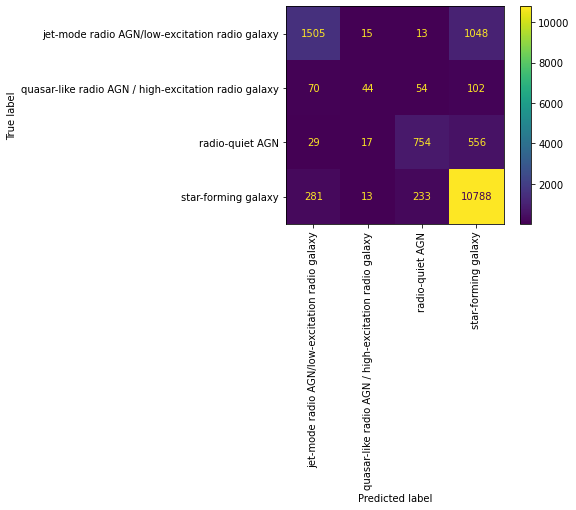

In [77]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [223]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=10000, 
                             class_weight="balanced",
                            early_stopping_round=50,
                            verbose=-1,
                            max_depth=7,
                            num_leaves=70,
                            min_data_in_leaf=10)

In [224]:
lightbm.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], sample_weight=classes_weights)

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


[1]	valid_0's multi_logloss: 2.5581	valid_1's multi_logloss: 2.55205
[2]	valid_0's multi_logloss: 2.28785	valid_1's multi_logloss: 2.27954
[3]	valid_0's multi_logloss: 2.1185	valid_1's multi_logloss: 2.10833
[4]	valid_0's multi_logloss: 1.98517	valid_1's multi_logloss: 1.97507
[5]	valid_0's multi_logloss: 1.88283	valid_1's multi_logloss: 1.87
[6]	valid_0's multi_logloss: 1.80526	valid_1's multi_logloss: 1.78855
[7]	valid_0's multi_logloss: 1.73584	valid_1's multi_logloss: 1.71711
[8]	valid_0's multi_logloss: 1.67903	valid_1's multi_logloss: 1.65938
[9]	valid_0's multi_logloss: 1.62492	valid_1's multi_logloss: 1.60329
[10]	valid_0's multi_logloss: 1.57178	valid_1's multi_logloss: 1.5485
[11]	valid_0's multi_logloss: 1.52952	valid_1's multi_logloss: 1.50396
[12]	valid_0's multi_logloss: 1.49251	valid_1's multi_logloss: 1.465
[13]	valid_0's multi_logloss: 1.45578	valid_1's multi_logloss: 1.42787
[14]	valid_0's multi_logloss: 1.4207	valid_1's multi_logloss: 1.39188
[15]	valid_0's multi_log

[117]	valid_0's multi_logloss: 0.646549	valid_1's multi_logloss: 0.490549
[118]	valid_0's multi_logloss: 0.644104	valid_1's multi_logloss: 0.487231
[119]	valid_0's multi_logloss: 0.641408	valid_1's multi_logloss: 0.48383
[120]	valid_0's multi_logloss: 0.639416	valid_1's multi_logloss: 0.481198
[121]	valid_0's multi_logloss: 0.636615	valid_1's multi_logloss: 0.477489
[122]	valid_0's multi_logloss: 0.63367	valid_1's multi_logloss: 0.473857
[123]	valid_0's multi_logloss: 0.631094	valid_1's multi_logloss: 0.470429
[124]	valid_0's multi_logloss: 0.629242	valid_1's multi_logloss: 0.467578
[125]	valid_0's multi_logloss: 0.626368	valid_1's multi_logloss: 0.463971
[126]	valid_0's multi_logloss: 0.623635	valid_1's multi_logloss: 0.460252
[127]	valid_0's multi_logloss: 0.621456	valid_1's multi_logloss: 0.457493
[128]	valid_0's multi_logloss: 0.618737	valid_1's multi_logloss: 0.454024
[129]	valid_0's multi_logloss: 0.616889	valid_1's multi_logloss: 0.451283
[130]	valid_0's multi_logloss: 0.614633	

[230]	valid_0's multi_logloss: 0.472628	valid_1's multi_logloss: 0.243774
[231]	valid_0's multi_logloss: 0.47188	valid_1's multi_logloss: 0.242517
[232]	valid_0's multi_logloss: 0.471288	valid_1's multi_logloss: 0.241485
[233]	valid_0's multi_logloss: 0.470268	valid_1's multi_logloss: 0.239979
[234]	valid_0's multi_logloss: 0.469581	valid_1's multi_logloss: 0.238589
[235]	valid_0's multi_logloss: 0.46841	valid_1's multi_logloss: 0.2367
[236]	valid_0's multi_logloss: 0.46764	valid_1's multi_logloss: 0.235742
[237]	valid_0's multi_logloss: 0.46661	valid_1's multi_logloss: 0.234359
[238]	valid_0's multi_logloss: 0.465526	valid_1's multi_logloss: 0.232588
[239]	valid_0's multi_logloss: 0.464901	valid_1's multi_logloss: 0.231253
[240]	valid_0's multi_logloss: 0.464105	valid_1's multi_logloss: 0.229845
[241]	valid_0's multi_logloss: 0.463086	valid_1's multi_logloss: 0.228369
[242]	valid_0's multi_logloss: 0.462079	valid_1's multi_logloss: 0.226855
[243]	valid_0's multi_logloss: 0.461505	vali

[345]	valid_0's multi_logloss: 0.401732	valid_1's multi_logloss: 0.121509
[346]	valid_0's multi_logloss: 0.401406	valid_1's multi_logloss: 0.12077
[347]	valid_0's multi_logloss: 0.401176	valid_1's multi_logloss: 0.120192
[348]	valid_0's multi_logloss: 0.400784	valid_1's multi_logloss: 0.119451
[349]	valid_0's multi_logloss: 0.400573	valid_1's multi_logloss: 0.118787
[350]	valid_0's multi_logloss: 0.400069	valid_1's multi_logloss: 0.117996
[351]	valid_0's multi_logloss: 0.399654	valid_1's multi_logloss: 0.117119
[352]	valid_0's multi_logloss: 0.39923	valid_1's multi_logloss: 0.116301
[353]	valid_0's multi_logloss: 0.399028	valid_1's multi_logloss: 0.115489
[354]	valid_0's multi_logloss: 0.398462	valid_1's multi_logloss: 0.11451
[355]	valid_0's multi_logloss: 0.398161	valid_1's multi_logloss: 0.113811
[356]	valid_0's multi_logloss: 0.397885	valid_1's multi_logloss: 0.11328
[357]	valid_0's multi_logloss: 0.397475	valid_1's multi_logloss: 0.112561
[358]	valid_0's multi_logloss: 0.396939	va

[459]	valid_0's multi_logloss: 0.374978	valid_1's multi_logloss: 0.0607218
[460]	valid_0's multi_logloss: 0.374941	valid_1's multi_logloss: 0.0603608
[461]	valid_0's multi_logloss: 0.374895	valid_1's multi_logloss: 0.0599685
[462]	valid_0's multi_logloss: 0.37458	valid_1's multi_logloss: 0.0595724
[463]	valid_0's multi_logloss: 0.374415	valid_1's multi_logloss: 0.059064
[464]	valid_0's multi_logloss: 0.37426	valid_1's multi_logloss: 0.0586785
[465]	valid_0's multi_logloss: 0.374202	valid_1's multi_logloss: 0.0583721
[466]	valid_0's multi_logloss: 0.37403	valid_1's multi_logloss: 0.057964
[467]	valid_0's multi_logloss: 0.374033	valid_1's multi_logloss: 0.0577117
[468]	valid_0's multi_logloss: 0.373792	valid_1's multi_logloss: 0.057274
[469]	valid_0's multi_logloss: 0.373735	valid_1's multi_logloss: 0.0568948
[470]	valid_0's multi_logloss: 0.37377	valid_1's multi_logloss: 0.0566256
[471]	valid_0's multi_logloss: 0.373575	valid_1's multi_logloss: 0.0562618
[472]	valid_0's multi_logloss: 0

[573]	valid_0's multi_logloss: 0.367538	valid_1's multi_logloss: 0.0298635
[574]	valid_0's multi_logloss: 0.367539	valid_1's multi_logloss: 0.0296637
[575]	valid_0's multi_logloss: 0.367536	valid_1's multi_logloss: 0.0294472
[576]	valid_0's multi_logloss: 0.367444	valid_1's multi_logloss: 0.0292438
[577]	valid_0's multi_logloss: 0.36748	valid_1's multi_logloss: 0.0290789
[578]	valid_0's multi_logloss: 0.367578	valid_1's multi_logloss: 0.0288994
[579]	valid_0's multi_logloss: 0.36762	valid_1's multi_logloss: 0.0286942
[580]	valid_0's multi_logloss: 0.367643	valid_1's multi_logloss: 0.0285239
[581]	valid_0's multi_logloss: 0.367752	valid_1's multi_logloss: 0.0283169
[582]	valid_0's multi_logloss: 0.367814	valid_1's multi_logloss: 0.0281698
[583]	valid_0's multi_logloss: 0.367748	valid_1's multi_logloss: 0.0279868
[584]	valid_0's multi_logloss: 0.367885	valid_1's multi_logloss: 0.0278391
[585]	valid_0's multi_logloss: 0.367914	valid_1's multi_logloss: 0.0276599
[586]	valid_0's multi_loglo

LGBMClassifier(class_weight='balanced', early_stopping_round=50, max_depth=7,
               min_data_in_leaf=10, n_estimators=10000, num_class=4,
               num_leaves=70, objective='multiclass', verbose=-1)

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [226]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7767    0.8694    0.8205      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5247    0.4333    0.4746       270
                                     radio-quiet AGN     0.6689    0.8105    0.7329      1356
                                 star-forming galaxy     0.9525    0.9064    0.9289     11315

                                            accuracy                         0.8836     15522
                                           macro avg     0.7307    0.7549    0.7392     15522
                                        weighted avg     0.8911    0.8836    0.8858     15522



[]

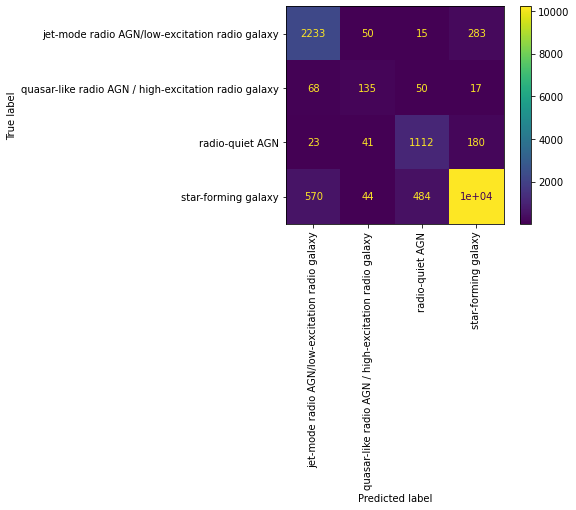

In [29]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# XGBoost

In [13]:
classes_weights2 = classes_weights.copy()
classes_weights2[classes_weights2>10] = classes_weights2[classes_weights2>10] = 100

In [187]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=7, 
                      reg_alpha=0, 
                      min_child_weight=0, 
                      reg_lambda=1,
                      eta=0.1,
                      subsample=1, # 1 normally
                      colsample_bytree=1, # 1 normally
                      tree_method='hist', # exact is more precies, but this is much faster
                      eval_metric=['merror', 'auc'],
                      objective='multi:softprob',
                      n_estimators=10000, 
                      early_stopping_rounds=100,)

In [188]:
bst = model.fit(X_train, y_train, 
                eval_set=[(X_test, y_test), (X_train, y_train)], verbose=True, 
                sample_weight=classes_weights
               ) # Maybe remove weight

[0]	validation_0-merror:0.22330	validation_0-auc:0.89845	validation_1-merror:0.21317	validation_1-auc:0.91143
[1]	validation_0-merror:0.21131	validation_0-auc:0.90571	validation_1-merror:0.20246	validation_1-auc:0.91856
[2]	validation_0-merror:0.20526	validation_0-auc:0.91170	validation_1-merror:0.19506	validation_1-auc:0.92372
[3]	validation_0-merror:0.20210	validation_0-auc:0.91427	validation_1-merror:0.19160	validation_1-auc:0.92674
[4]	validation_0-merror:0.20236	validation_0-auc:0.91598	validation_1-merror:0.18849	validation_1-auc:0.92902
[5]	validation_0-merror:0.20062	validation_0-auc:0.91802	validation_1-merror:0.18667	validation_1-auc:0.93106
[6]	validation_0-merror:0.20055	validation_0-auc:0.91931	validation_1-merror:0.18489	validation_1-auc:0.93254
[7]	validation_0-merror:0.19933	validation_0-auc:0.92060	validation_1-merror:0.18385	validation_1-auc:0.93387
[8]	validation_0-merror:0.19662	validation_0-auc:0.92222	validation_1-merror:0.18150	validation_1-auc:0.93558
[9]	valida

[74]	validation_0-merror:0.15243	validation_0-auc:0.95444	validation_1-merror:0.11455	validation_1-auc:0.97711
[75]	validation_0-merror:0.15146	validation_0-auc:0.95468	validation_1-merror:0.11366	validation_1-auc:0.97748
[76]	validation_0-merror:0.15108	validation_0-auc:0.95489	validation_1-merror:0.11297	validation_1-auc:0.97779
[77]	validation_0-merror:0.15069	validation_0-auc:0.95511	validation_1-merror:0.11228	validation_1-auc:0.97809
[78]	validation_0-merror:0.15017	validation_0-auc:0.95517	validation_1-merror:0.11154	validation_1-auc:0.97833
[79]	validation_0-merror:0.14953	validation_0-auc:0.95530	validation_1-merror:0.11104	validation_1-auc:0.97857
[80]	validation_0-merror:0.14882	validation_0-auc:0.95556	validation_1-merror:0.10968	validation_1-auc:0.97891
[81]	validation_0-merror:0.14869	validation_0-auc:0.95573	validation_1-merror:0.10920	validation_1-auc:0.97921
[82]	validation_0-merror:0.14818	validation_0-auc:0.95583	validation_1-merror:0.10870	validation_1-auc:0.97941
[

[148]	validation_0-merror:0.13065	validation_0-auc:0.96148	validation_1-merror:0.07465	validation_1-auc:0.99027
[149]	validation_0-merror:0.13072	validation_0-auc:0.96150	validation_1-merror:0.07427	validation_1-auc:0.99040
[150]	validation_0-merror:0.13020	validation_0-auc:0.96156	validation_1-merror:0.07367	validation_1-auc:0.99050
[151]	validation_0-merror:0.13020	validation_0-auc:0.96159	validation_1-merror:0.07346	validation_1-auc:0.99058
[152]	validation_0-merror:0.13007	validation_0-auc:0.96160	validation_1-merror:0.07314	validation_1-auc:0.99066
[153]	validation_0-merror:0.12982	validation_0-auc:0.96162	validation_1-merror:0.07269	validation_1-auc:0.99076
[154]	validation_0-merror:0.12949	validation_0-auc:0.96166	validation_1-merror:0.07245	validation_1-auc:0.99085
[155]	validation_0-merror:0.12956	validation_0-auc:0.96166	validation_1-merror:0.07214	validation_1-auc:0.99092
[156]	validation_0-merror:0.12943	validation_0-auc:0.96174	validation_1-merror:0.07158	validation_1-auc:

[222]	validation_0-merror:0.12196	validation_0-auc:0.96370	validation_1-merror:0.05033	validation_1-auc:0.99572
[223]	validation_0-merror:0.12118	validation_0-auc:0.96374	validation_1-merror:0.04987	validation_1-auc:0.99579
[224]	validation_0-merror:0.12131	validation_0-auc:0.96378	validation_1-merror:0.04945	validation_1-auc:0.99584
[225]	validation_0-merror:0.12131	validation_0-auc:0.96384	validation_1-merror:0.04912	validation_1-auc:0.99588
[226]	validation_0-merror:0.12099	validation_0-auc:0.96388	validation_1-merror:0.04885	validation_1-auc:0.99593
[227]	validation_0-merror:0.12125	validation_0-auc:0.96389	validation_1-merror:0.04854	validation_1-auc:0.99597
[228]	validation_0-merror:0.12118	validation_0-auc:0.96389	validation_1-merror:0.04822	validation_1-auc:0.99603
[229]	validation_0-merror:0.12093	validation_0-auc:0.96391	validation_1-merror:0.04811	validation_1-auc:0.99605
[230]	validation_0-merror:0.12067	validation_0-auc:0.96394	validation_1-merror:0.04776	validation_1-auc:

[296]	validation_0-merror:0.11410	validation_0-auc:0.96530	validation_1-merror:0.03208	validation_1-auc:0.99835
[297]	validation_0-merror:0.11397	validation_0-auc:0.96531	validation_1-merror:0.03179	validation_1-auc:0.99836
[298]	validation_0-merror:0.11397	validation_0-auc:0.96531	validation_1-merror:0.03162	validation_1-auc:0.99838
[299]	validation_0-merror:0.11390	validation_0-auc:0.96531	validation_1-merror:0.03134	validation_1-auc:0.99840
[300]	validation_0-merror:0.11371	validation_0-auc:0.96530	validation_1-merror:0.03120	validation_1-auc:0.99841
[301]	validation_0-merror:0.11384	validation_0-auc:0.96530	validation_1-merror:0.03094	validation_1-auc:0.99842
[302]	validation_0-merror:0.11358	validation_0-auc:0.96529	validation_1-merror:0.03070	validation_1-auc:0.99845
[303]	validation_0-merror:0.11326	validation_0-auc:0.96532	validation_1-merror:0.03054	validation_1-auc:0.99847
[304]	validation_0-merror:0.11326	validation_0-auc:0.96532	validation_1-merror:0.03043	validation_1-auc:

[370]	validation_0-merror:0.10965	validation_0-auc:0.96613	validation_1-merror:0.01936	validation_1-auc:0.99939
[371]	validation_0-merror:0.10946	validation_0-auc:0.96614	validation_1-merror:0.01923	validation_1-auc:0.99940
[372]	validation_0-merror:0.10952	validation_0-auc:0.96614	validation_1-merror:0.01910	validation_1-auc:0.99941
[373]	validation_0-merror:0.10946	validation_0-auc:0.96615	validation_1-merror:0.01896	validation_1-auc:0.99942
[374]	validation_0-merror:0.10946	validation_0-auc:0.96615	validation_1-merror:0.01886	validation_1-auc:0.99942
[375]	validation_0-merror:0.10933	validation_0-auc:0.96614	validation_1-merror:0.01880	validation_1-auc:0.99943
[376]	validation_0-merror:0.10920	validation_0-auc:0.96614	validation_1-merror:0.01867	validation_1-auc:0.99944
[377]	validation_0-merror:0.10920	validation_0-auc:0.96615	validation_1-merror:0.01851	validation_1-auc:0.99944
[378]	validation_0-merror:0.10888	validation_0-auc:0.96615	validation_1-merror:0.01841	validation_1-auc:

[444]	validation_0-merror:0.10643	validation_0-auc:0.96673	validation_1-merror:0.01164	validation_1-auc:0.99980
[445]	validation_0-merror:0.10637	validation_0-auc:0.96674	validation_1-merror:0.01166	validation_1-auc:0.99980
[446]	validation_0-merror:0.10591	validation_0-auc:0.96678	validation_1-merror:0.01160	validation_1-auc:0.99980
[447]	validation_0-merror:0.10604	validation_0-auc:0.96678	validation_1-merror:0.01142	validation_1-auc:0.99980
[448]	validation_0-merror:0.10604	validation_0-auc:0.96678	validation_1-merror:0.01139	validation_1-auc:0.99980
[449]	validation_0-merror:0.10611	validation_0-auc:0.96677	validation_1-merror:0.01127	validation_1-auc:0.99981
[450]	validation_0-merror:0.10617	validation_0-auc:0.96678	validation_1-merror:0.01116	validation_1-auc:0.99981
[451]	validation_0-merror:0.10611	validation_0-auc:0.96679	validation_1-merror:0.01110	validation_1-auc:0.99982
[452]	validation_0-merror:0.10585	validation_0-auc:0.96679	validation_1-merror:0.01094	validation_1-auc:

[518]	validation_0-merror:0.10289	validation_0-auc:0.96732	validation_1-merror:0.00654	validation_1-auc:0.99995
[519]	validation_0-merror:0.10289	validation_0-auc:0.96732	validation_1-merror:0.00647	validation_1-auc:0.99995
[520]	validation_0-merror:0.10282	validation_0-auc:0.96733	validation_1-merror:0.00646	validation_1-auc:0.99995
[521]	validation_0-merror:0.10269	validation_0-auc:0.96734	validation_1-merror:0.00638	validation_1-auc:0.99995
[522]	validation_0-merror:0.10276	validation_0-auc:0.96736	validation_1-merror:0.00631	validation_1-auc:0.99995
[523]	validation_0-merror:0.10276	validation_0-auc:0.96735	validation_1-merror:0.00630	validation_1-auc:0.99995
[524]	validation_0-merror:0.10289	validation_0-auc:0.96736	validation_1-merror:0.00623	validation_1-auc:0.99995
[525]	validation_0-merror:0.10302	validation_0-auc:0.96735	validation_1-merror:0.00622	validation_1-auc:0.99995
[526]	validation_0-merror:0.10302	validation_0-auc:0.96736	validation_1-merror:0.00609	validation_1-auc:

[592]	validation_0-merror:0.10153	validation_0-auc:0.96769	validation_1-merror:0.00359	validation_1-auc:0.99999
[593]	validation_0-merror:0.10128	validation_0-auc:0.96770	validation_1-merror:0.00356	validation_1-auc:0.99999
[594]	validation_0-merror:0.10121	validation_0-auc:0.96770	validation_1-merror:0.00353	validation_1-auc:0.99999
[595]	validation_0-merror:0.10128	validation_0-auc:0.96770	validation_1-merror:0.00351	validation_1-auc:0.99999
[596]	validation_0-merror:0.10140	validation_0-auc:0.96771	validation_1-merror:0.00351	validation_1-auc:0.99999
[597]	validation_0-merror:0.10140	validation_0-auc:0.96771	validation_1-merror:0.00351	validation_1-auc:0.99999
[598]	validation_0-merror:0.10108	validation_0-auc:0.96771	validation_1-merror:0.00343	validation_1-auc:0.99999
[599]	validation_0-merror:0.10102	validation_0-auc:0.96771	validation_1-merror:0.00340	validation_1-auc:0.99999
[600]	validation_0-merror:0.10089	validation_0-auc:0.96771	validation_1-merror:0.00337	validation_1-auc:

[666]	validation_0-merror:0.10037	validation_0-auc:0.96795	validation_1-merror:0.00177	validation_1-auc:1.00000
[667]	validation_0-merror:0.10024	validation_0-auc:0.96796	validation_1-merror:0.00177	validation_1-auc:1.00000
[668]	validation_0-merror:0.10005	validation_0-auc:0.96797	validation_1-merror:0.00176	validation_1-auc:1.00000
[669]	validation_0-merror:0.10018	validation_0-auc:0.96797	validation_1-merror:0.00174	validation_1-auc:1.00000
[670]	validation_0-merror:0.10031	validation_0-auc:0.96798	validation_1-merror:0.00169	validation_1-auc:1.00000
[671]	validation_0-merror:0.10044	validation_0-auc:0.96798	validation_1-merror:0.00171	validation_1-auc:1.00000
[672]	validation_0-merror:0.10005	validation_0-auc:0.96797	validation_1-merror:0.00168	validation_1-auc:1.00000
[673]	validation_0-merror:0.09986	validation_0-auc:0.96797	validation_1-merror:0.00166	validation_1-auc:1.00000
[674]	validation_0-merror:0.09966	validation_0-auc:0.96798	validation_1-merror:0.00161	validation_1-auc:

[740]	validation_0-merror:0.10024	validation_0-auc:0.96814	validation_1-merror:0.00066	validation_1-auc:1.00000
[741]	validation_0-merror:0.09999	validation_0-auc:0.96814	validation_1-merror:0.00064	validation_1-auc:1.00000
[742]	validation_0-merror:0.09986	validation_0-auc:0.96815	validation_1-merror:0.00061	validation_1-auc:1.00000
[743]	validation_0-merror:0.09966	validation_0-auc:0.96815	validation_1-merror:0.00060	validation_1-auc:1.00000
[744]	validation_0-merror:0.09973	validation_0-auc:0.96815	validation_1-merror:0.00056	validation_1-auc:1.00000
[745]	validation_0-merror:0.09960	validation_0-auc:0.96815	validation_1-merror:0.00055	validation_1-auc:1.00000
[746]	validation_0-merror:0.09986	validation_0-auc:0.96816	validation_1-merror:0.00055	validation_1-auc:1.00000
[747]	validation_0-merror:0.09979	validation_0-auc:0.96815	validation_1-merror:0.00055	validation_1-auc:1.00000
[748]	validation_0-merror:0.10005	validation_0-auc:0.96816	validation_1-merror:0.00053	validation_1-auc:

[814]	validation_0-merror:0.09979	validation_0-auc:0.96833	validation_1-merror:0.00014	validation_1-auc:1.00000
[815]	validation_0-merror:0.09979	validation_0-auc:0.96833	validation_1-merror:0.00014	validation_1-auc:1.00000
[816]	validation_0-merror:0.09966	validation_0-auc:0.96833	validation_1-merror:0.00014	validation_1-auc:1.00000
[817]	validation_0-merror:0.09973	validation_0-auc:0.96835	validation_1-merror:0.00014	validation_1-auc:1.00000
[818]	validation_0-merror:0.09979	validation_0-auc:0.96835	validation_1-merror:0.00014	validation_1-auc:1.00000
[819]	validation_0-merror:0.09979	validation_0-auc:0.96836	validation_1-merror:0.00014	validation_1-auc:1.00000
[820]	validation_0-merror:0.09966	validation_0-auc:0.96835	validation_1-merror:0.00014	validation_1-auc:1.00000
[821]	validation_0-merror:0.09960	validation_0-auc:0.96836	validation_1-merror:0.00014	validation_1-auc:1.00000
[822]	validation_0-merror:0.09973	validation_0-auc:0.96835	validation_1-merror:0.00014	validation_1-auc:

[888]	validation_0-merror:0.09883	validation_0-auc:0.96845	validation_1-merror:0.00003	validation_1-auc:1.00000
[889]	validation_0-merror:0.09915	validation_0-auc:0.96846	validation_1-merror:0.00003	validation_1-auc:1.00000
[890]	validation_0-merror:0.09889	validation_0-auc:0.96846	validation_1-merror:0.00003	validation_1-auc:1.00000
[891]	validation_0-merror:0.09889	validation_0-auc:0.96846	validation_1-merror:0.00003	validation_1-auc:1.00000
[892]	validation_0-merror:0.09883	validation_0-auc:0.96846	validation_1-merror:0.00003	validation_1-auc:1.00000
[893]	validation_0-merror:0.09896	validation_0-auc:0.96847	validation_1-merror:0.00003	validation_1-auc:1.00000
[894]	validation_0-merror:0.09909	validation_0-auc:0.96847	validation_1-merror:0.00003	validation_1-auc:1.00000
[895]	validation_0-merror:0.09902	validation_0-auc:0.96847	validation_1-merror:0.00003	validation_1-auc:1.00000
[896]	validation_0-merror:0.09896	validation_0-auc:0.96847	validation_1-merror:0.00002	validation_1-auc:

[]

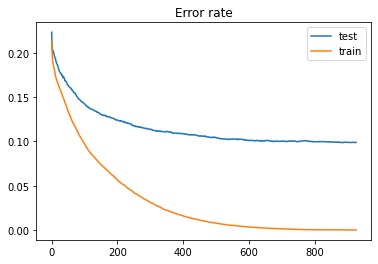

In [189]:
errors_test = bst.evals_result()['validation_0']['merror']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['merror']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('Error rate')
plt.legend()
plt.plot()

[]

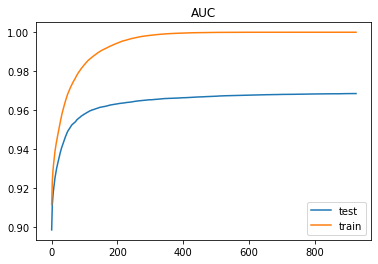

In [190]:
errors_test = bst.evals_result()['validation_0']['auc']
plt.plot(range(len(errors_test)), errors_test, label='test')
errors_train = bst.evals_result()['validation_1']['auc']
plt.plot(range(len(errors_train)), errors_train, label='train')
plt.title('AUC')
plt.legend()
plt.plot()

In [195]:
cross_val_model = XGBClassifier(use_label_encoder=False, 
                      max_depth=7, 
                      reg_alpha=0, 
                      min_child_weight=0, 
                      reg_lambda=1,
                      eta=0.1,
                      subsample=1, # 1 normally
                      colsample_bytree=1, # 1 normally
                      tree_method='hist', # exact is more precies, but this is much faster
                      eval_metric=['merror', 'auc'],
                      objective='multi:softprob',
                      n_estimators=1000)

In [ ]:
cv_score_xgb = cross_val_score(cross_val_model, X_train, y_train, cv=8, n_jobs=-1, scoring="accuracy")

In [ ]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

In [192]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8305    0.8392    0.8348      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5829    0.4037    0.4770       270
                                     radio-quiet AGN     0.7404    0.7780    0.7587      1356
                                 star-forming galaxy     0.9416    0.9405    0.9411     11315

                                            accuracy                         0.9001     15522
                                           macro avg     0.7738    0.7404    0.7529     15522
                                        weighted avg     0.8993    0.9001    0.8994     15522



[]

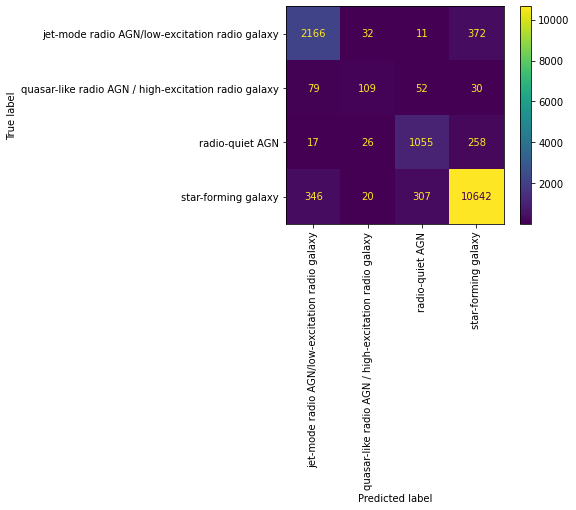

In [193]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

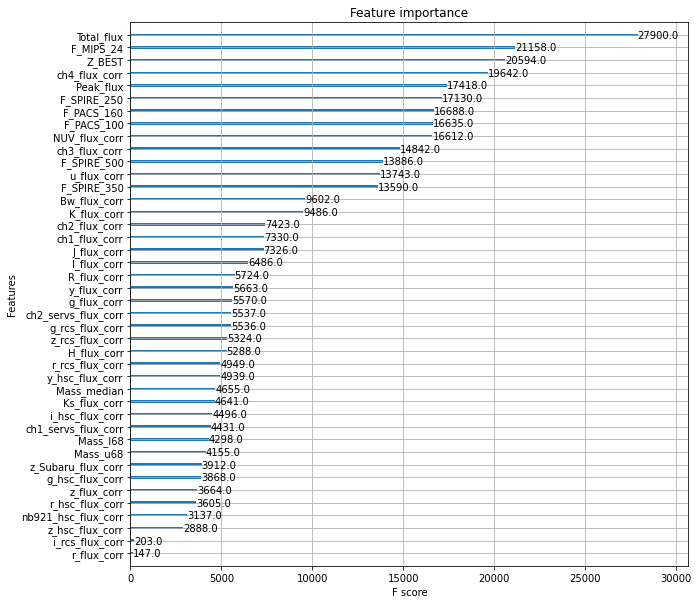

In [194]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

# Adaboost

In [197]:
from sklearn.ensemble import AdaBoostClassifier

In [207]:
ada = AdaBoostClassifier(n_estimators=50, learning_rate=0.3, random_state=42)

In [208]:
ada.fit(X_train, y_train, sample_weight=classes_weights)

AdaBoostClassifier(learning_rate=0.3, random_state=42)

In [209]:
y_pred = ada.predict(X_train)
print(classification_report(y_train, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.4535    0.5478    0.4962     10186
quasar-like radio AGN / high-excitation radio galaxy     0.1239    0.4896    0.1978      1062
                                     radio-quiet AGN     0.4399    0.6761    0.5330      5514
                                 star-forming galaxy     0.8776    0.7186    0.7902     45325

                                            accuracy                         0.6829     62087
                                           macro avg     0.4738    0.6080    0.5043     62087
                                        weighted avg     0.7563    0.6829    0.7090     62087



In [210]:
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.4391    0.5339    0.4819      2581
quasar-like radio AGN / high-excitation radio galaxy     0.1155    0.4667    0.1852       270
                                     radio-quiet AGN     0.4225    0.6652    0.5168      1356
                                 star-forming galaxy     0.8730    0.7066    0.7810     11315

                                            accuracy                         0.6701     15522
                                           macro avg     0.4625    0.5931    0.4912     15522
                                        weighted avg     0.7483    0.6701    0.6978     15522



# DNN

In [28]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [70]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

In [71]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [72]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)

In [74]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=1000,
    callbacks=[early_stopping],
    validation_data=(X_test, y_test),
    class_weight=class_weight_dic,
)

Epoch 1/1000
1941/1941 [==============================] - 5s 2ms/step - loss: 1.2237 - accuracy: 0.5100 - val_loss: 1.1177 - val_accuracy: 0.6102
Epoch 2/1000
1941/1941 [==============================] - 5s 2ms/step - loss: 1.1852 - accuracy: 0.5153 - val_loss: 1.1890 - val_accuracy: 0.2875
Epoch 3/1000
1047/1941 [===============>..............] - ETA: 2s - loss: 1.1610 - accuracy: 0.5283

KeyboardInterrupt: 